In [1]:
import torch

In [2]:
import sys
sys.path.insert(0, '../../')
import numpy as np
from model.ick import ICK
from utils.train import Trainer
from kernels.kernel_fn import *
from utils.helpers import *
from tqdm.notebook import tqdm

import gpytorch
from gpytorch.kernels import LinearKernel

# To make this notebook's output stable across runs
np.random.seed(2020)
torch.manual_seed(2020)
torch.cuda.manual_seed(2020)
torch.cuda.manual_seed_all(2020)
torch.backends.cudnn.deterministic = True

## 1. Use a GP with RBF kernel to fit the data

In [3]:
x_train = torch.FloatTensor(100).uniform_(-3., 3.)
y_train = torch.sin(2*np.pi*x_train) * torch.exp(-x_train) + torch.randn(x_train.size()) * np.sqrt(0.5)

In [4]:
# GP model definition
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(x_train, y_train, likelihood)

# Print hyperparameters before training
hypers = {
    'likelihood.noise_covar.noise': torch.tensor(0.1),
    'covar_module.base_kernel.lengthscale': torch.tensor(0.5),
    'covar_module.outputscale': torch.tensor(1.),
}
model.initialize(**hypers)

# Training
model.train()
likelihood.train()
epochs = 1000
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
num_epochs = tqdm(range(epochs), position=0, leave=True)
for i in num_epochs:
    optimizer.zero_grad()
    output = model(x_train)
    loss = -mll(output, y_train)
    loss.backward()
    num_epochs.set_description('Iter %d/%d - Loss: %.3f' % (
        i + 1, epochs, loss.item()
    ))
    optimizer.step()

  0%|          | 0/1000 [00:00<?, ?it/s]

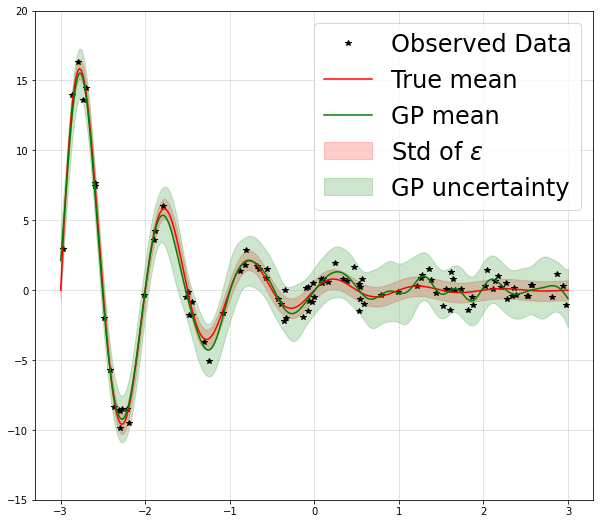

In [5]:
# Plot the model fit
model.eval()
likelihood.eval()

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    x_test = torch.linspace(-3., 3., 300)
    y_test_mean = torch.sin(2*np.pi*x_test) * torch.exp(-x_test)
    y_test = y_test_mean + torch.randn(x_test.size()) * np.sqrt(0.5)
    observed_pred = likelihood(model(x_test))
    
with torch.no_grad():
    f, ax = plt.subplots(1, 1, figsize=(10,9))
    lower, upper = observed_pred.confidence_region()
    ax.plot(x_train.numpy(), y_train.numpy(), 'k*')
    ax.plot(x_test.numpy(), y_test_mean.numpy(), c='r')
    ax.plot(x_test.numpy(), observed_pred.mean.numpy(), c='g')
    ax.fill_between(x_test.numpy(), y_test_mean.numpy()-np.sqrt(0.5), y_test_mean.numpy()+np.sqrt(0.5), color='r', alpha=0.2)
    ax.fill_between(x_test.numpy(), lower.numpy(), upper.numpy(), color='g', alpha=0.2)
    ax.set_ylim([-15.,20.])
    ax.legend(['Observed Data', 'True mean', 'GP mean', 'Std of $\epsilon$', 'GP uncertainty'], prop={'size': 24})
    ax.grid(ls='--', lw=0.5)

## 2. Use ICKy with a single RBF kernel to fit the data

In [ ]:
data_generators = create_generators_from_data(
    x_train.numpy(), y_train.numpy(), x_test.numpy(), y_test.numpy(), train_batch_size=100)
kernel_assignment = ['ImplicitNystromKernel']
kernel_params = {
    'ImplicitNystromKernel': {
        'kernel_func': sq_exp_kernel_nys, 
        'params': ['std','lengthscale','noise'], 
        'vals': [1., 0.5, 0.1], 
        'trainable': [True,True,True], 
        'alpha': 1e-5, 
        'num_inducing_points': 32, 
        'nys_space': [[-3.,3.]]
    }
}
model = ICK(kernel_assignment, kernel_params)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
optim = 'adam'
optim_params = {
    'lr': 0.1, 
    'weight_decay': 0.0
}
epochs, patience = 1000, 1000
trainer = Trainer(
    model=model,
    data_generators=data_generators,
    optim=optim,
    optim_params=optim_params, 
    model_save_dir=None,
    device=device,
    epochs=epochs,
    patience=patience,
    validation=False
)
trainer.train()

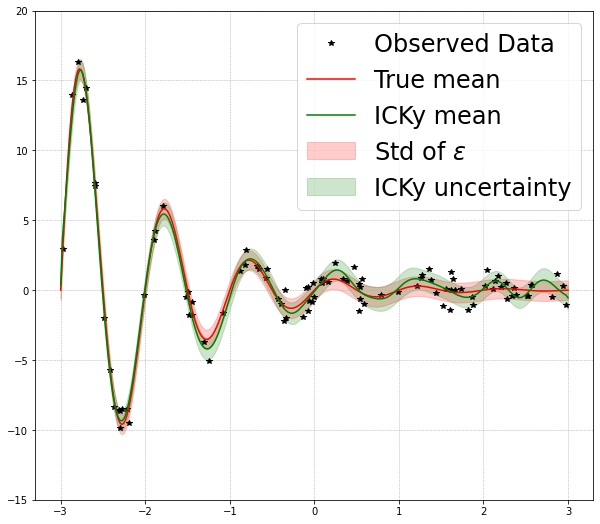

In [13]:
y_test_pred, _, lower, upper, = trainer.predict(uncertainty=True)

with torch.no_grad():
    f, ax = plt.subplots(1, 1, figsize=(10,9))
    ax.plot(x_train.numpy(), y_train.numpy(), 'k*')
    ax.plot(x_test.numpy(), y_test_mean.numpy(), c='r')
    ax.plot(x_test.numpy(), y_test_pred, c='g')
    ax.fill_between(x_test.numpy(), y_test_mean.numpy()-np.sqrt(0.5), y_test_mean.numpy()+np.sqrt(0.5), color='r', alpha=0.2)
    ax.fill_between(x_test.numpy(), lower, upper, color='g', alpha=0.2)
    ax.set_ylim([-15.,20.])
    ax.legend(['Observed Data', 'True mean', 'ICKy mean', 'Std of $\epsilon$', 'ICKy uncertainty'], prop={'size': 24})
    ax.grid(ls='--', lw=0.5)